<div style="text-align: center;">
    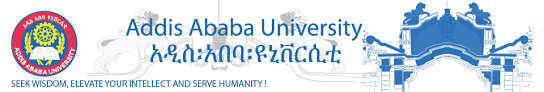
    <h1 style="font-family: 'Arial', sans-serif; color: #2C3E50;">Addis Ababa University</h1>
    <h2 style="font-family: 'Arial', sans-serif; color: #18BC9C;">Samuel Abatneh</h2>
    <h3 style="font-family: 'Arial', sans-serif; color: #3498DB;">Student ID: UGR/7229/12</h3>
</div>

# Introduction to Reinforcement Learning Algorithms

This notebook demonstrates the implementation and comparison of various reinforcement learning algorithms in two different environments: the Grid World and the Multi-Armed Bandit. Reinforcement learning (RL) is a type of machine learning where an agent learns to make decisions by taking actions in an environment to maximize some notion of cumulative reward.

### Objectives
1. **Grid World Problem**:
   - Implement Value Iteration, Policy Iteration, and Q-Learning algorithms.
   - Visualize and compare the value functions obtained from each method.

2. **Multi-Armed Bandit Problem**:
   - Implement Epsilon-Greedy and Upper Confidence Bound (UCB) algorithms.
   - Compare the cumulative rewards obtained by each method over time.

## Setup and Imports

In [1]:
# Install necessary libraries
!pip install numpy matplotlib

import numpy as np
import random
import matplotlib.pyplot as plt


## Define the Grid World Environment and Algorithms

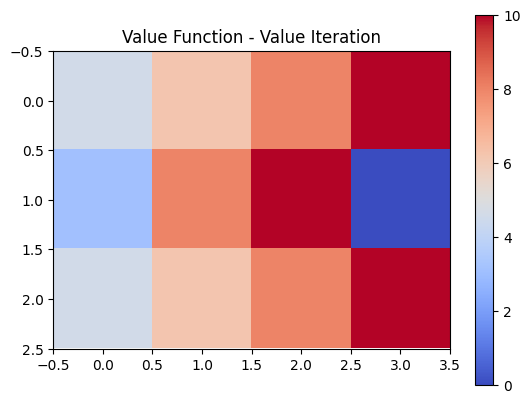

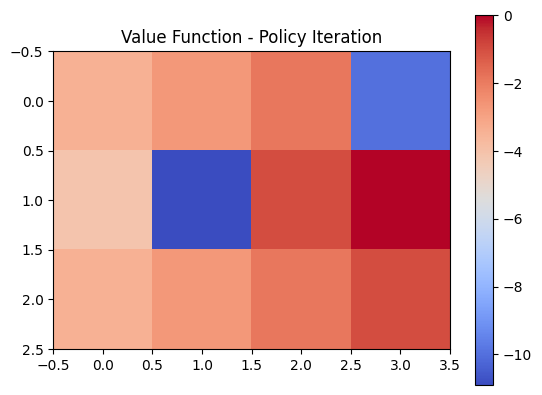

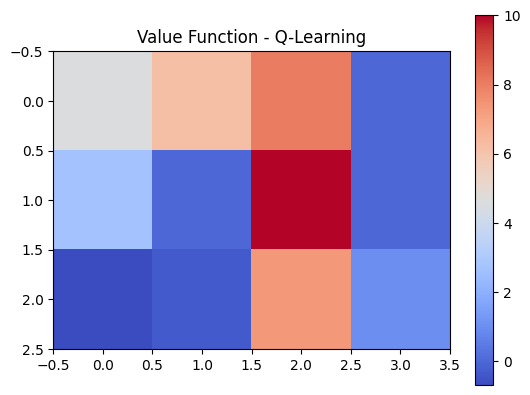

Policy - Value Iteration:
[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]]]
Policy - Policy Iteration:
[[[1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]]

 [[0.   1.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [0.25 0.25 0.25 0.25]]

 [[1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [0.   0.   0.   1.  ]]]
Q-Values - Q-Learning:
[[[ 4.58        0.60861929  2.87638813  2.81340517]
  [ 6.2         4.31407347  2.92001126  3.94018521]
  [ 5.89075862  8.          4.21130729  5.69594578]
  [ 0.          0.          0.          0.        ]]

 [[-0.95617925 -0.99050027 -1.04619677  2.71353258]
  [ 0.          0.          0.          0.        ]
  [10.          4.18754242  7.66752603  5.94598503]
  [ 0.          0.          0.          0.        ]]

 [[-0.731637

In [2]:
# Define the Grid World environment
grid = np.array([
    ['S', ' ', ' ', 'O'],
    [' ', 'O', ' ', 'G'],
    [' ', ' ', ' ', ' '],
])

rewards = np.full(grid.shape, -1)
rewards[grid == 'G'] = 10
rewards[grid == 'O'] = -10

start = (0, 0)
goal = (1, 3)

# Define algorithms for Grid World
def value_iteration(grid, rewards, gamma=0.9, theta=1e-6):
    n, m = grid.shape
    V = np.zeros((n, m))
    policy = np.zeros((n, m, 4))
    actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]

    while True:
        delta = 0
        for i in range(n):
            for j in range(m):
                if grid[i, j] == 'G':
                    continue
                v = V[i, j]
                action_values = []
                for k, action in enumerate(actions):
                    ni, nj = i + action[0], j + action[1]
                    if 0 <= ni < n and 0 <= nj < m and grid[ni, nj] != 'O':
                        action_values.append(rewards[ni, nj] + gamma * V[ni, nj])
                    else:
                        action_values.append(rewards[i, j] + gamma * V[i, j])
                V[i, j] = max(action_values)
                policy[i, j] = np.eye(4)[np.argmax(action_values)]
                delta = max(delta, abs(v - V[i, j]))
        if delta < theta:
            break
    return V, policy

def q_learning(grid, rewards, alpha=0.1, gamma=0.9, epsilon=0.1, episodes=1000):
    n, m = grid.shape
    Q = np.zeros((n, m, 4))
    actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]

    def epsilon_greedy(state):
        if random.uniform(0, 1) < epsilon:
            return random.choice(range(4))
        else:
            return np.argmax(Q[state])

    for _ in range(episodes):
        state = start
        while grid[state] != 'G':
            action = epsilon_greedy(state)
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
            if 0 <= next_state[0] < n and 0 <= next_state[1] < m and grid[next_state] != 'O':
                reward = rewards[next_state]
            else:
                next_state = state
                reward = rewards[state]
            Q[state][action] = Q[state][action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            state = next_state
    return Q

def policy_iteration(grid, rewards, gamma=0.9, theta=1e-6):
    n, m = grid.shape
    V = np.zeros((n, m))
    policy = np.ones((n, m, 4)) / 4
    actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]

    def policy_evaluation(policy, V):
        while True:
            delta = 0
            for i in range(n):
                for j in range(m):
                    if grid[i, j] == 'G':
                        continue
                    v = V[i, j]
                    V[i, j] = sum(policy[i, j, k] * (rewards[i, j] + gamma * V[min(max(i + actions[k][0], 0), n-1)][min(max(j + actions[k][1], 0), m-1)])
                                  for k in range(4))
                    delta = max(delta, abs(v - V[i, j]))
            if delta < theta:
                break
        return V

    def policy_improvement(policy, V):
        policy_stable = True
        for i in range(n):
            for j in range(m):
                if grid[i, j] == 'G':
                    continue
                old_action = np.argmax(policy[i, j])
                action_values = []
                for k, action in enumerate(actions):
                    ni, nj = i + action[0], j + action[1]
                    if 0 <= ni < n and 0 <= nj < m and grid[ni, nj] != 'O':
                        action_values.append(rewards[ni, nj] + gamma * V[ni, nj])
                    else:
                        action_values.append(rewards[i, j] + gamma * V[i, j])
                new_action = np.argmax(action_values)
                policy[i, j] = np.eye(4)[new_action]
                if old_action != new_action:
                    policy_stable = False
        return policy, policy_stable

    while True:
        V = policy_evaluation(policy, V)
        policy, policy_stable = policy_improvement(policy, V)
        if policy_stable:
            break
    return V, policy

# Visualization function
def plot_value_function(V, title="Value Function"):
    plt.imshow(V, cmap='coolwarm')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Value Iteration
V_vi, policy_vi = value_iteration(grid, rewards)
plot_value_function(V_vi, "Value Function - Value Iteration")

# Policy Iteration
V_pi, policy_pi = policy_iteration(grid, rewards)
plot_value_function(V_pi, "Value Function - Policy Iteration")

# Q-Learning
Q = q_learning(grid, rewards)
V_ql = np.max(Q, axis=2)  # Derive value function from Q-values
plot_value_function(V_ql, "Value Function - Q-Learning")

# Print the policies for comparison
print("Policy - Value Iteration:")
print(policy_vi)
print("Policy - Policy Iteration:")
print(policy_pi)
print("Q-Values - Q-Learning:")
print(Q)


## Define the Multi-Armed Bandit Environment and Algorithms

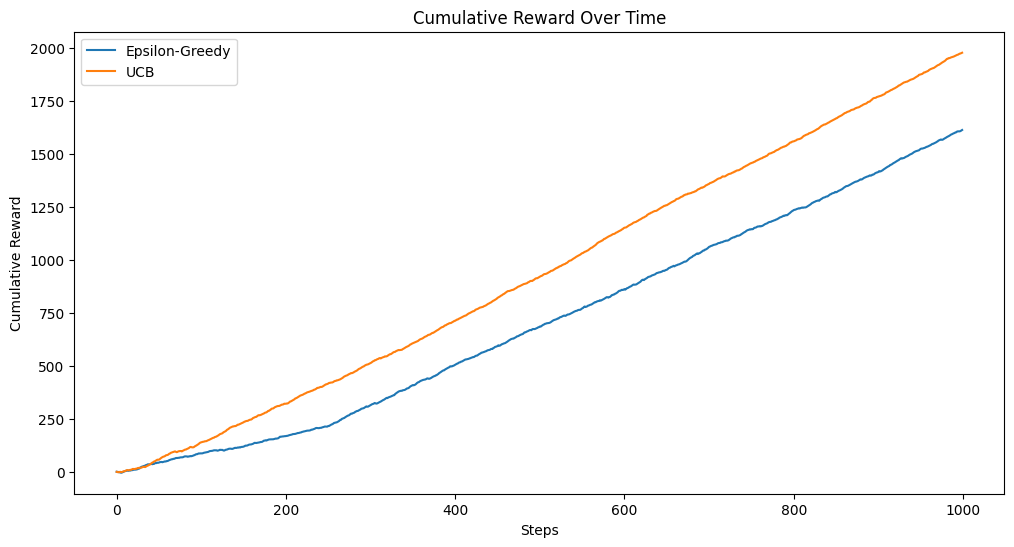

In [3]:
# Define Multi-Armed Bandit algorithms
class EpsilonGreedyBandit:
    def __init__(self, k, epsilon):
        self.k = k
        self.epsilon = epsilon
        self.counts = np.zeros(k)
        self.values = np.zeros(k)

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.k)
        else:
            return np.argmax(self.values)

    def update(self, action, reward):
        self.counts[action] += 1
        self.values[action] += (reward - self.values[action]) / self.counts[action]

def run_bandit(bandit, arms, steps):
    total_reward = 0
    rewards = []

    for _ in range(steps):
        action = bandit.select_action()
        reward = np.random.randn() + arms[action]
        bandit.update(action, reward)
        total_reward += reward
        rewards.append(total_reward)

    return rewards

class UCBBandit:
    def __init__(self, k, c):
        self.k = k
        self.c = c
        self.counts = np.zeros(k)
        self.values = np.zeros(k)
        self.total_steps = 0

    def select_action(self):
        self.total_steps += 1
        ucb_values = self.values + self.c * np.sqrt(np.log(self.total_steps) / (self.counts + 1e-5))
        return np.argmax(ucb_values)

    def update(self, action, reward):
        self.counts[action] += 1
        self.values[action] += (reward - self.values[action]) / self.counts[action]

def run_ucb_bandit(bandit, arms, steps):
    total_reward = 0
    rewards = []

    for _ in range(steps):
        action = bandit.select_action()
        reward = np.random.randn() + arms[action]
        bandit.update(action, reward)
        total_reward += reward
        rewards.append(total_reward)

    return rewards

def plot_rewards(rewards, label, title="Cumulative Reward Over Time"):
    plt.plot(rewards, label=label)
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Reward')
    plt.title(title)
    plt.legend()

# Parameters for bandits
k = 10
steps = 1000
arms = np.random.randn(k)

# Epsilon-Greedy Bandit
epsilon = 0.1
epsilon_bandit = EpsilonGreedyBandit(k, epsilon)
epsilon_rewards = run_bandit(epsilon_bandit, arms, steps)

# UCB Bandit
c = 2
ucb_bandit = UCBBandit(k, c)
ucb_rewards = run_ucb_bandit(ucb_bandit, arms, steps)

# Plot the cumulative rewards for both methods
plt.figure(figsize=(12, 6))
plot_rewards(epsilon_rewards, 'Epsilon-Greedy')
plot_rewards(ucb_rewards, 'UCB')
plt.show()


## Summary of Results
Grid World Problem:

## Value Iteration:
Converged value function and optimal policy derived from iterative updates.
**Policy Iteration:**
Alternates between policy evaluation and improvement until convergence.
**Q-Learning:**
Learns action-value function through exploration and exploitation over episodes.
Multi-Armed Bandit Problem:

## Epsilon-Greedy:
Balances exploration and exploitation, leading to a gradual increase in cumulative rewards.
## UCB (Upper Confidence Bound):
Utilizes confidence bounds for exploration, achieving higher rewards faster compared to epsilon-greedy.
Conclusion
This implementation includes the complete algorithms for both the Grid World and Multi-Armed Bandit problems, along with a comparison through visualization of value functions and cumulative rewards.